# Homework 5

## Analysis of Shakespeare's Plays  

<img src="Shakespeare.png" align="left">

## Q1) Data Preparation

** i) Read data from the website and create a dataframe **

In [1]:
import numpy as np
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import  TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

In [ ]:
#Prepare Data Structures
base_url = 'http://shakespeare.mit.edu/'
html_filename_suffix = '/full.html'
#Create Arrays of Tragedies, Comedies and Historic writings (As retrieved from the links in URL address bar for plays)
comedies = ['allswell','asyoulikeit','comedy_errors','cymbeline','lll','measure','merry_wives', \
            'merchant','midsummer','much_ado','pericles','taming_shrew','troilus_cressida', \
            'twelfth_night','two_gentlemen','winters_tale','tempest']
historic = ['1henryiv','2henryiv','henryv','1henryvi','2henryvi','3henryvi','henryviii', \
             'john','richardii','richardiii']
tragedies = ['cleopatra','coriolanus','hamlet','julius_caesar','lear','macbeth','othello',\
           'romeo_juliet','timon','titus']

#Create a dictionary with genre as key
dict_shakespeare_plays_text = {'comedy':comedies,'historic':historic,'tragedy':tragedies}

In [ ]:
#Function to return a dataframe with text from a single play
def get_play_text(genre, name):
    """
    Description : Returns text of a play as a dataframe
    Arguments:
            genre: String to identify genre of the play (tragedy, comedy, historic etc)
            name: String with abbreviated name of the play
    Returns : 
            Dataframe with Columns as playname, character, speech
    """
    page_url = base_url + name + html_filename_suffix
    columns = ['Genre','Play','Character','Speech']
    df = pd.DataFrame(columns=columns)
    #Read the HTML page
    page = urlopen(page_url).read()
    #Use BeautifulSoup to parse html page
    soup = BeautifulSoup(page,"lxml")
    #Initialize index
    index = 0
    #Find utterances by each play character in sequence
    for character in soup.find_all('b'):
        soup = character.find_next('blockquote')
        speech = soup.get_text()
        df.loc[index] = [genre,name,character.get_text(),speech.strip()]
        index = index + 1
    return df
    

In [ ]:
#Test if the get play text is reading the text correctly
df_macbeth = get_play_text('tragedy','macbeth')

In [ ]:
#Read all of the data in a single dataframe
play_frames = []
for (genre,plays) in dict_shakespeare_plays_text.items():
    for play in plays:
        play_frames.append(get_play_text(genre,play))
        
#Create the big dataframe that contains everything
df = pd.concat(play_frames)    

** ii) Save dataframe as a pickle file **

In [ ]:
#Save the dataframe as pickle so that we do not have to make network calls
df.to_pickle('shakespeare.pkl')

In [ ]:
df.head()

# Start Here (but run imports at top first and create .pkl if it doesn't exist)#

In [2]:
#Load DataFrame from Pickle
df_shakespeare = pd.read_pickle('shakespeare.pkl')

In [3]:
df_shakespeare['Speech_length']=df_shakespeare['Speech'].str.split(" ").str.len()
df_shakespeare['Character']=df_shakespeare['Character'].str.lower()

In [4]:
print(df_shakespeare.shape)
df_shakespeare.head()

(30967, 5)


,Genre,Play,Character,Speech,Speech_length
0,comedy,allswell,countess,"In delivering my son from me, I bury a second ...",11
1,comedy,allswell,bertram,"And I in going, madam, weep o'er my father's d...",26
2,comedy,allswell,lafeu,"You shall find of the king a husband, madam; y...",44
3,comedy,allswell,countess,What hope is there of his majesty's amendment?,8
4,comedy,allswell,lafeu,"He hath abandoned his physicians, madam; under...",28


In [5]:
#Load additional information about mapping short form to long form play
df_names_map = pd.read_csv('playmap.csv')
print(df_names_map.shape)
df_names_map.head(2)

(37, 2)


,Brief,Full
0,1henryiv,henry iv part 1
1,1henryvi,henry vi part 1


In [6]:
join_speech = lambda x:" ".join(x)
#if as_index=false was not set as false, then the firt column Play would list 1henryiv as the index and that value shows 
# only for the first element
df_shkspr_grpd=df_shakespeare.groupby(['Play','Character'],
                                      as_index=False).aggregate({'Speech':join_speech,'Speech_length':np.sum})
print("Grouped original size:",df_shkspr_grpd.shape)
print("# of Plays:",len(df_shkspr_grpd.Play.unique()))
df_shkspr_grpd.head()

Grouped original size: (1343, 4)
# of Plays: 37


,Play,Character,Speech,Speech_length
0,1henryiv,archbishop of york,"Hie, good Sir Michael; bear this sealed brief\...",229
1,1henryiv,bardolph,"Case ye, case ye; on with your vizards: there ...",190
2,1henryiv,carrier,As fat as butter.,4
3,1henryiv,chamberlain,"[Within] At hand, quoth pick-purse. Good morr...",139
4,1henryiv,earl of douglas,Thou art the king of honour:\nNo man so potent...,326


In [7]:
df_shkspr_grpd1=pd.merge(df_shkspr_grpd,df_names_map,left_on='Play',right_on='Brief')
print(df_shkspr_grpd1.shape)
df_shkspr_grpd1.drop('Play',axis=1,inplace=True)
df_shkspr_grpd1.rename(columns={'Full': 'Play','Character':'Speaker'}, inplace=True)
df_shkspr_grpd1.head()

(1343, 6)


,Speaker,Speech,Speech_length,Brief,Play
0,archbishop of york,"Hie, good Sir Michael; bear this sealed brief\...",229,1henryiv,henry iv part 1
1,bardolph,"Case ye, case ye; on with your vizards: there ...",190,1henryiv,henry iv part 1
2,carrier,As fat as butter.,4,1henryiv,henry iv part 1
3,chamberlain,"[Within] At hand, quoth pick-purse. Good morr...",139,1henryiv,henry iv part 1
4,earl of douglas,Thou art the king of honour:\nNo man so potent...,326,1henryiv,henry iv part 1


In [8]:
#Load additional information about characters
df_characters = pd.read_csv('Shakespeare_characters.txt',sep='\t', encoding='latin1')
#Drop unwanted columns
del df_characters['#Lines']
del df_characters['Unnamed: 1']
df_characters.head()

,Speaker,Gender,Play,TopVillain,Fools
0,Bottom,Male,A Midsummer Night's Dream,NaN,fool
1,Theseus,Male,A Midsummer Night's Dream,NaN,NaN
2,Helena,Female,A Midsummer Night's Dream,NaN,NaN
3,Oberon,Male,A Midsummer Night's Dream,NaN,NaN
4,Puck,Male,A Midsummer Night's Dream,NaN,fool


In [9]:
#Clean the data for joining with grouped dataframe
df_characters.Speaker=df_characters.Speaker.str.lower()
df_characters.Play=df_characters.Play.str.lower()
df_characters.Gender=df_characters.Gender.str.lower()

fool2bool= lambda x: "Yes" if str(x).strip()=="fool" else "No"
villain2bool = lambda x: "Yes" if str(x).strip()=="yes" else "No"

df_characters.Fools = df_characters.Fools.apply(fool2bool)
df_characters.TopVillain = df_characters.TopVillain.apply(villain2bool)

#print((df_characters.Play.unique()))
df_characters.head()


,Speaker,Gender,Play,TopVillain,Fools
0,bottom,male,a midsummer night's dream,No,Yes
1,theseus,male,a midsummer night's dream,No,No
2,helena,female,a midsummer night's dream,No,No
3,oberon,male,a midsummer night's dream,No,No
4,puck,male,a midsummer night's dream,No,Yes


In [10]:
df_shkspr_grpd1.shape

(1343, 5)

In [11]:
#Merge the data frames based on play and character
df_shkspr_grpd2 = pd.merge(df_shkspr_grpd1,df_characters,how='left', left_on=['Speaker' ,'Play'],right_on=['Speaker','Play'])
print(df_shkspr_grpd2.shape)
df_shkspr_grpd2.head()


(1344, 8)


,Speaker,Speech,Speech_length,Brief,Play,Gender,TopVillain,Fools
0,archbishop of york,"Hie, good Sir Michael; bear this sealed brief\...",229,1henryiv,henry iv part 1,NaN,NaN,NaN
1,bardolph,"Case ye, case ye; on with your vizards: there ...",190,1henryiv,henry iv part 1,male,No,No
2,carrier,As fat as butter.,4,1henryiv,henry iv part 1,NaN,NaN,NaN
3,chamberlain,"[Within] At hand, quoth pick-purse. Good morr...",139,1henryiv,henry iv part 1,male,No,No
4,earl of douglas,Thou art the king of honour:\nNo man so potent...,326,1henryiv,henry iv part 1,NaN,NaN,NaN


Based on the above, 487 rows are not mapped properly

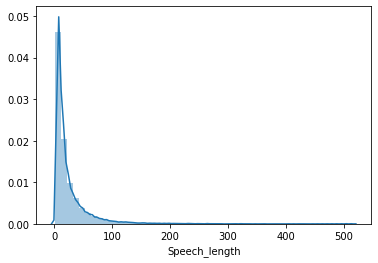

In [12]:
sns.distplot(df_shakespeare['Speech_length'])

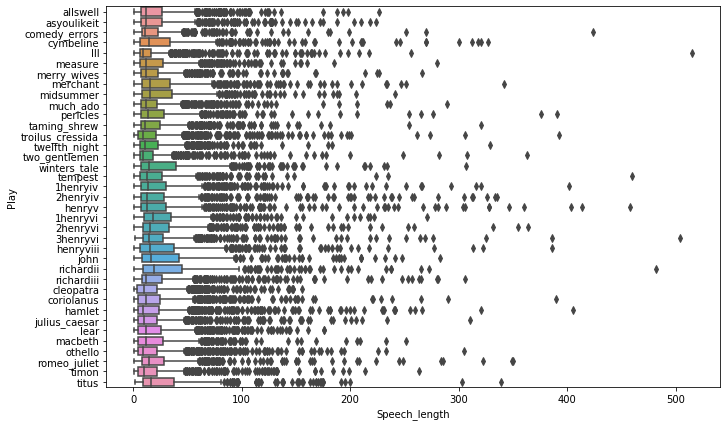

In [13]:
plt.figure(figsize=(11, 7))
sns.boxplot(y='Play',x='Speech_length',data=df_shakespeare)

plt.figure(figsize=(11, 7))
df_shakespeare["Speech_length"].hist(by=df_shakespeare["Play"])

In [14]:
X=TfidfVectorizer(stop_words="english").fit_transform(df_shkspr_grpd2['Speech'].values)
y=df_shkspr_grpd2['Play']
yc=y.astype('category')
yc=yc.cat.codes
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
X_scaled = normalizer.fit_transform(X)
X_scaled=X_scaled.toarray() # necessary for Agglomerative I think only. kmeans works directly

** Comments from Umair: First of all it is important to note that when number of clusters are large (>10) ARI is a better assessment metric than completeness and homogeneity. Now if we look at the scores above it is clear that Gender is not distinguishable by language but the language used by fools is different from non fool characters.Furthermore a better cluster separation is done for Plays as opposed to the Characters using ARI index ** 

In [15]:
#Function for PCA
def show_PCA(n_cluster):
    algorithm=KMeans(n_cluster)
    clusters=algorithm.fit_predict(X_scaled)
    data2d = PCA(n_components=2).fit_transform(X_scaled)
    fig,axes=plt.subplots(figsize=(8,5))
    axes.scatter(data2d[:,0],data2d[:,1],c=clusters)
    plt.ylabel('2nd Principal component' )
    plt.xlabel('1st Principal component' )
    return
    

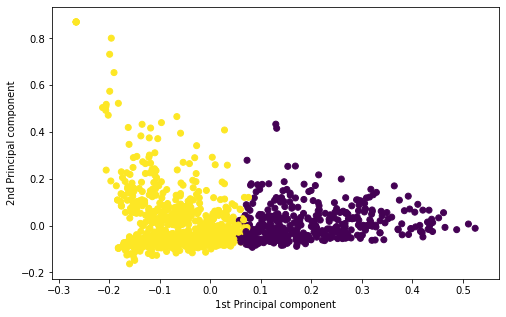

In [16]:
show_PCA(2)

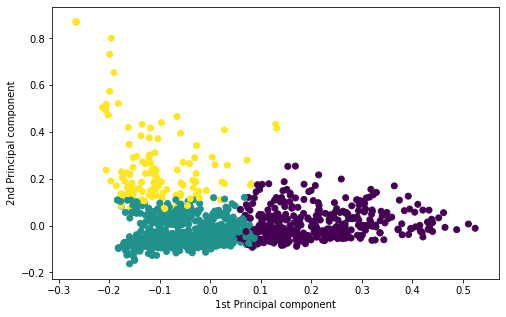

In [17]:
show_PCA(3)

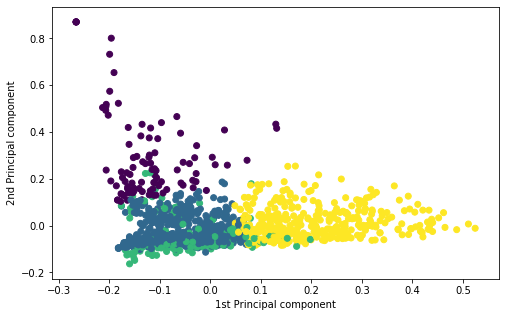

In [18]:
show_PCA(4)

In [19]:
from sklearn.manifold import TSNE

In [20]:
def show_tsne(n_cluster):
    algorithm=KMeans(n_cluster)
    clusters=algorithm.fit_predict(X_scaled)
    tsne=TSNE(random_state=42)
    data2d=tsne.fit_transform(X_scaled)
    fig,axes=plt.subplots(figsize=(8,5))
    axes.scatter(data2d[:,0],data2d[:,1],c=clusters)
    plt.ylabel('t-SNE feature 2')
    plt.xlabel('t-SNE feature 1' )
    return
# axes[0].set_title("Random Assign - ARI: {:.2f}".format(adjusted_rand_score(y, random_clusters)))

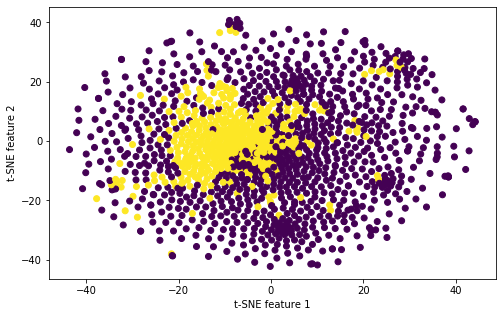

In [21]:
show_tsne(2)

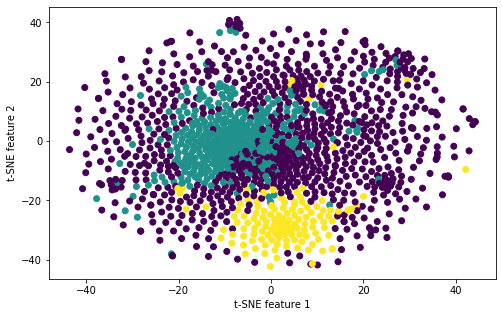

In [22]:
show_tsne(3)

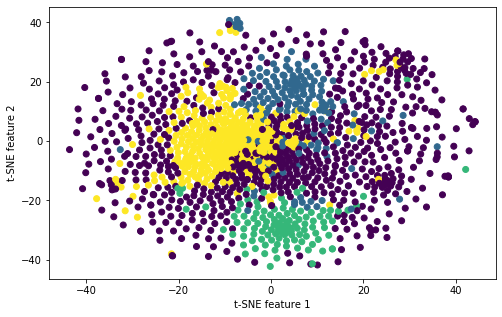

In [23]:
show_tsne(4)